In [1]:
import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


Data are aggregated from df_info (its city information is used to merge weather information - also rating might be used for model training), fsq_park_type, dynamic data include weather_info & df_curr_popularity. 

hour and day_of_week are extracted from datetime_hour.

In [98]:
# load current
# df_curr_popularity = pd.read_parquet('curr_popularity_Date_2021-03-16_2021-04-10.parquet')
df_curr_popularity = pd.read_parquet('curr_popularity_Date_2021-03-16_2021-04-20.parquet')
# df_weather = pd.read_parquet('weather_data_Date_2021-03-16_2021-04-10.parquet')
df_weather = pd.read_parquet('weather_data_Date_2021-03-16_2021-04-20.parquet')


In [99]:
len(df_curr_popularity['id'].unique())

1505

In [125]:
df_curr_popularity.head()

,datetime_hour,id,curr_popularity,rating_n,request_id,avg_popularity
0,2021-04-07 01:00:00,ChIJ2R92Tl7Gx4kRO6G7NcWtNhk,34.0,1360.0,ChIJ2R92Tl7Gx4kRO6G7NcWtNhk,0.0
1,2021-04-07 01:00:00,ChIJ6RplJk13xokRN0DaW7aoDaA,46.0,441.0,ChIJ6RplJk13xokRN0DaW7aoDaA,0.0
2,2021-04-07 01:00:00,ChIJBf9gK23kx4kR7d1LnPPvyp8,1.0,593.0,ChIJBf9gK23kx4kR7d1LnPPvyp8,1.0
3,2021-04-07 01:00:00,ChIJKfnD4cK9x4kRHA-LRHfOQYs,23.0,1532.0,ChIJKfnD4cK9x4kRHA-LRHfOQYs,3.0
4,2021-04-07 01:00:00,ChIJOwA0J6YCuIkRaK-0pk4S95E,7.0,301.0,ChIJOwA0J6YCuIkRaK-0pk4S95E,0.0


In [100]:
df_weather.shape

(330048, 24)

### Get 3 info table

In [16]:
from utility import get_info, find_city_level_address

In [238]:
# import importlib
importlib.reload(utility)

<module 'utility' from '/Users/chengqiu/PycharmProjects/philly_outdoors/utility.py'>

In [101]:
info_to_concat = []
info_list = ['philly_parks_info.db', 'philly_state_parks_info.db', 'nyc_parks_info.db']
for info_db in info_list:
    df = get_info(info_db)
    info_to_concat.append(df)
    
info_df = pd.concat(info_to_concat, axis=0)

In [102]:
info_df.drop_duplicates(subset='id', inplace=True, ignore_index=True)
print(info_df.shape)
info_df.head()

(4601, 6)


,id,name,rating,lat,lng,address
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,4.7,38.937670,-76.500899,"600 Quiet Waters Park Rd, Annapolis, MD 21403,..."
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,5.0,38.927212,-76.494150,"101 W Bay View Dr, Annapolis, MD 21403, USA"
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,4.7,38.930202,-76.508341,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ..."
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,4.8,38.931865,-76.505658,"600 Quiet Waters Park Rd, Annapolis, MD 21403,..."
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,4.5,38.963271,-76.505150,"273 Hilltop Ln, Annapolis, MD 21403, USA"


In [103]:
info_df['address_city'] = info_df['address'].apply(find_city_level_address)

Cannot find city-level address: Rothrock State Forest, Pennsylvania 16669, USA


In [44]:
info_df.head()

,id,name,lat,lng,address,address_city
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,38.937670,-76.500899,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...","Annapolis,MD"
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,38.927212,-76.494150,"101 W Bay View Dr, Annapolis, MD 21403, USA","Annapolis,MD"
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,38.930202,-76.508341,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ...","Annapolis,MD"
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,38.931865,-76.505658,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...","Annapolis,MD"
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,38.963271,-76.505150,"273 Hilltop Ln, Annapolis, MD 21403, USA","Annapolis,MD"


### FourSquare park type

In [104]:
park_type_df = pd.concat([pd.read_parquet('philly_park_foursquare_types.parquet'), 
                          pd.read_parquet('nyc_park_foursquare_types.parquet')], axis=0)


In [249]:
print(park_type_df.shape)
park_type_df.head()

(4473, 8)


,id,name,lat,lng,fsq_name,fsq_type_name,fsq_type_id,fsq_type_name_simplified
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,38.937670,-76.500899,Quiet Waters Park,Park,4bf58dd8d48988d163941735,Park
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,38.927212,-76.494150,Hillsmere Shores Beach and Playground,Playground,4bf58dd8d48988d1e7941735,Playground
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,38.930202,-76.508341,,,,None
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,38.931865,-76.505658,Quiet Waters Dog Park,Dog Run,4bf58dd8d48988d1e5941735,Dog Run
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,38.963271,-76.505150,"""Pip"" Moyer Recreation Center",Gym,4bf58dd8d48988d176941735,Athletics & Sports


In [84]:
park_type_df['fsq_type_name_simplified'].unique()

array(['Park', 'Playground', None, 'Dog Run', 'Athletics & Sports',
       'Other Great Outdoors', 'Harbor / Marina', 'Plaza',
       'Arts & Entertainment', 'State / Provincial Park', 'Campground',
       'River', 'Travel & Transport', 'Shop & Service', 'Trail',
       'Scenic Lookout', 'Professional & Other Places', 'Bike Trail',
       'Nature Preserve', 'Outdoors & Recreation', 'Beach', 'Field',
       'Lake', 'Fishing Spot', 'Pool', 'Farm', 'Bridge',
       'Botanical Garden', 'College & University', 'Nightlife Spot',
       'Cemetery', 'Food', 'Vineyard', 'National Park',
       'Recreation Center', 'Garden', 'Sculpture Garden', 'Ski Area',
       'Island', 'Pedestrian Plaza', 'Forest', 'Waterfall', 'Picnic Area',
       'Roof Deck', 'Waterfront'], dtype=object)

In [105]:
# add fsq_type to info_df
info_df_wt_fsq_type = info_df.merge(park_type_df[['id', 'fsq_type_name_simplified']], how='left', on='id')
info_df_wt_fsq_type.head()

,id,name,rating,lat,lng,address,address_city,fsq_type_name_simplified
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,4.7,38.937670,-76.500899,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...","Annapolis,MD",Park
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,5.0,38.927212,-76.494150,"101 W Bay View Dr, Annapolis, MD 21403, USA","Annapolis,MD",Playground
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,4.7,38.930202,-76.508341,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ...","Annapolis,MD",None
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,4.8,38.931865,-76.505658,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...","Annapolis,MD",Dog Run
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,4.5,38.963271,-76.505150,"273 Hilltop Ln, Annapolis, MD 21403, USA","Annapolis,MD",Athletics & Sports


In [106]:
# add state parks to info_df_wt_fsq_type (only when fsq_type_name_simplified is none)
philly_state_park_id = get_info('philly_state_parks_info.db')['id']

park_id_missing_fsq_type = info_df_wt_fsq_type[info_df_wt_fsq_type['fsq_type_name_simplified'].isna()]['id']
state_park_id = set(park_id_missing_fsq_type).intersection(set(philly_state_park_id))

info_df_wt_fsq_type.set_index('id', inplace=True)
info_df_wt_fsq_type.loc[state_park_id, ['fsq_type_name_simplified']] = 'State / Provincial Park'

In [107]:
# # fill in the rest with 'Park' - opt out, now use SimpleImputer to create a new "missing_value" category 
info_df_wt_fsq_type = info_df_wt_fsq_type.reset_index()
# info_df_wt_fsq_type.loc[np.where(info_df_wt_fsq_type['fsq_type_name_simplified'].isna())[0], 
#                         ['fsq_type_name_simplified']] = 'Park'

In [255]:
info_df_wt_fsq_type.head()

,id,name,rating,lat,lng,address,address_city,fsq_type_name_simplified
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,4.7,38.937670,-76.500899,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...","Annapolis,MD",Park
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,5.0,38.927212,-76.494150,"101 W Bay View Dr, Annapolis, MD 21403, USA","Annapolis,MD",Playground
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,4.7,38.930202,-76.508341,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ...","Annapolis,MD",None
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,4.8,38.931865,-76.505658,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...","Annapolis,MD",Dog Run
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,4.5,38.963271,-76.505150,"273 Hilltop Ln, Annapolis, MD 21403, USA","Annapolis,MD",Athletics & Sports


In [256]:
info_df_wt_fsq_type[info_df_wt_fsq_type['id'] == 'ChIJ2R92Tl7Gx4kRO6G7NcWtNhk']

,id,name,rating,lat,lng,address,address_city,fsq_type_name_simplified
252,ChIJ2R92Tl7Gx4kRO6G7NcWtNhk,Susquehanna State Park,4.7,39.604816,-76.15167,"4188 Wilkinson Rd, Havre De Grace, MD 21078, USA","Havre De Grace,MD",None


In [90]:
Counter(info_df_wt_fsq_type['fsq_type_name_simplified']); 

In [432]:
info_df_wt_fsq_type[info_df_wt_fsq_type['fsq_type_name_simplified']=='Travel & Transport'].head()

,id,name,lat,lng,address,address_city,fsq_type_name_simplified
35,ChIJU-taUeGcyIkRmOMiqeRIRks,Columbia Crossing River Trails Center,40.030361,-76.507988,"41 Walnut St, Columbia, PA 17512, USA","Columbia,PA",Travel & Transport
437,ChIJP7LWOW_TxYkRyQ-J7WbddUs,Bowers Park,40.485966,-75.743690,"Mertztown, PA 19539, USA","Mertztown,PA",Travel & Transport
678,ChIJhQi4JJGRxokRpVHYWzwCpOM,Lock 60 Recreation Area,40.144674,-75.508518,"Locktender's House, 400 Tow Path Rd, Mont Clar...","Mont Clare,PA",Travel & Transport
1151,ChIJreKNFonIxokRPfXi7jRKom0,Cherry Street Pier,39.952446,-75.138918,"121 N Christopher Columbus Blvd, Philadelphia,...","Philadelphia,PA",Travel & Transport
1801,ChIJW8juxou6w4kR5ESMsW9EEjQ,Connell Corporate Park,40.664624,-74.414364,"Plainfield Ave, Berkeley Heights, NJ 07922, USA","Berkeley Heights,NJ",Travel & Transport


## include fsq_type and address_city to df_curr_popularity

In [108]:
df_curr_popularity = df_curr_popularity.merge(info_df_wt_fsq_type[['id', 'address_city', 'fsq_type_name_simplified', 
                                                                   'rating']], how='left', on='id')

In [437]:
#Travel & Transport
df_curr_popularity[df_curr_popularity['fsq_type_name_simplified']=='Playground']['id'].unique();

## merge curr_popularity and weather tabel
The main dataframe is merged from curr_popularity and weather_info table (by city and datetime)

In [109]:
df_popularity = df_curr_popularity.merge(df_weather, how='left', left_on=['address_city', 'datetime_hour'], 
                         right_on=['location', 'datetime'])

In [110]:
df_popularity['hour'] = df_popularity['datetime_hour'].apply(lambda x:x.hour) # extract hour & dayofweek from datetime_hour
df_popularity['dayofweek'] = df_popularity['datetime_hour'].apply(lambda x:x.dayofweek)

In [125]:
# df_popularity.to_parquet('data_v1_Date_2021-03-16_2021-04-10.parquet')
# df_popularity.to_parquet('data_v1_Date_2021-03-16_2021-04-20.parquet')
df_popularity = pd.read_parquet('data_v1_Date_2021-03-16_2021-04-20.parquet')


In [112]:
df_popularity.shape

(507886, 35)

In [101]:
# the ones without temp but with address_city
df_popularity.loc[df_popularity['temp'].isna() & ~df_popularity['address_city'].isna(), 
                  ['address_city', 'location', 'datetime', 'datetime_hour']]


,address_city,location,datetime,datetime_hour
4447,"Hainesport,NJ",NaN,NaT,2021-04-19
4448,"Norristown,PA",NaN,NaT,2021-04-19
4449,"Philadelphia,PA",NaN,NaT,2021-04-19
4450,"Langhorne,PA",NaN,NaT,2021-04-19
4451,"Delanco,NJ",NaN,NaT,2021-04-19
...,...,...,...,...
507881,"Rutherford,NJ",NaN,NaT,2021-04-17
507882,"White Plains,NY",NaN,NaT,2021-04-17
507883,"Springfield Gardens,NY",NaN,NaT,2021-04-17
507884,"Brooklyn,NY",NaN,NaT,2021-04-17


In [135]:
df_popularity.loc[df_popularity['temp'].isna() & (df_popularity['address_city'] == 'Paterson,NJ')]

,datetime_hour,id,curr_popularity,rating_n,request_id,address_city,fsq_type_name_simplified,datetimeEpoch,temp,feelslike,...,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,datetime,location,latitude,longitude
222626,2021-04-11 00:00:00,ChIJS4XXJM_9wokRi4GvZ-DecfM,51.5,523.0,ChIJS4XXJM_9wokRi4GvZ-DecfM,"Paterson,NJ",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
222684,2021-04-11 00:00:00,ChIJdTSF-9z9wokRj0-PHUdG8WE,53.0,603.0,ChIJdTSF-9z9wokRj0-PHUdG8WE,"Paterson,NJ",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
222884,2021-04-11 01:00:00,ChIJS4XXJM_9wokRi4GvZ-DecfM,26.0,523.0,ChIJS4XXJM_9wokRi4GvZ-DecfM,"Paterson,NJ",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
222935,2021-04-11 01:00:00,ChIJdTSF-9z9wokRj0-PHUdG8WE,52.0,603.0,ChIJdTSF-9z9wokRj0-PHUdG8WE,"Paterson,NJ",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
223087,2021-04-11 02:00:00,ChIJS4XXJM_9wokRi4GvZ-DecfM,51.0,523.0,ChIJS4XXJM_9wokRi4GvZ-DecfM,"Paterson,NJ",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
223116,2021-04-11 02:00:00,ChIJdTSF-9z9wokRj0-PHUdG8WE,21.0,603.0,ChIJdTSF-9z9wokRj0-PHUdG8WE,"Paterson,NJ",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [127]:
no_weather_cities = df_popularity.loc[
    df_popularity['temp'].isna() & ~df_popularity['address_city'].isna(), 'address_city'].unique().tolist()

all_weather_cities = df_weather['location'].unique().tolist()

# city not queried for weather
cities_with_no_weather = set(no_weather_cities) - set(all_weather_cities)

In [137]:
len(set(no_weather_cities) & set(all_weather_cities))

174

In [7]:
len(df_popularity['id'].unique())

1287

In [234]:
city_address = sorted(list(cities_with_no_weather))[0]
print(city_address)
df_popularity[df_popularity['address_city'] == city_address]#['id'].unique()
# summary of cases:
# https://docs.google.com/spreadsheets/d/1pYvh83GEh9OoXm04vl3sstvis7wrDN7Q3FW3_MHK2JA/edit#gid=0

Aberdeen,MD


,datetime_hour,id,curr_popularity,rating_n,request_id,address_city,fsq_type_name_simplified,datetimeEpoch,temp,feelslike,...,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,datetime,location,latitude,longitude
73992,2021-04-10 20:00:00,ChIJdX36VZrBx4kR9kEZqQJiHBY,82.0,300.0,ChIJdX36VZrBx4kR9kEZqQJiHBY,"Aberdeen,MD",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
74215,2021-04-10 21:00:00,ChIJdX36VZrBx4kR9kEZqQJiHBY,46.0,300.0,ChIJdX36VZrBx4kR9kEZqQJiHBY,"Aberdeen,MD",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
74392,2021-04-10 22:00:00,ChIJdX36VZrBx4kR9kEZqQJiHBY,22.0,300.0,ChIJdX36VZrBx4kR9kEZqQJiHBY,"Aberdeen,MD",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
74644,2021-04-11 00:00:00,ChIJdX36VZrBx4kR9kEZqQJiHBY,34.0,300.0,ChIJdX36VZrBx4kR9kEZqQJiHBY,"Aberdeen,MD",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
74734,2021-04-11 01:00:00,ChIJdX36VZrBx4kR9kEZqQJiHBY,131.0,300.0,ChIJdX36VZrBx4kR9kEZqQJiHBY,"Aberdeen,MD",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
74806,2021-04-11 02:00:00,ChIJdX36VZrBx4kR9kEZqQJiHBY,131.0,300.0,ChIJdX36VZrBx4kR9kEZqQJiHBY,"Aberdeen,MD",Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


## Data visualization

In [113]:
from ipywidgets import widgets
import matplotlib.pyplot as plt

X = df_popularity.drop(columns=['curr_popularity', ])
y = df_popularity['curr_popularity']

def data_plot(X, y):
    def plotter(column):
        valid_rows = X[column].notna()
        plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k', alpha=0.01)
        plt.xticks(rotation = 90)
        plt.xlabel(column)
        plt.ylabel('Current popularity')
    
    return plotter

dropdown_values = df_popularity.columns #{"{0}: {1}".format(k, features_dict[k]):k for k in X.columns}
widgets.interact(data_plot(X, y), column=dropdown_values);

interactive(children=(Dropdown(description='column', options=('datetime_hour', 'id', 'curr_popularity', 'ratin…

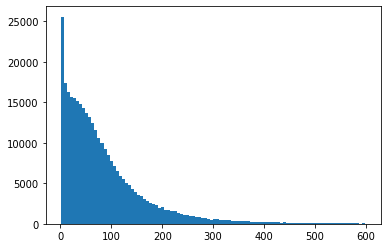

In [330]:
plt.hist(df_popularity[df_popularity['curr_popularity']<600]['curr_popularity'], 100); 

In [24]:
df_popularity[df_popularity['curr_popularity']>2000]

,datetime_hour,id,curr_popularity,rating_n,request_id,address_city,fsq_type_name_simplified,datetimeEpoch,temp,feelslike,...,solarradiation,solarenergy,uvindex,conditions,datetime,location,latitude,longitude,hour,dayofweek
53094,2021-04-08 20:00:00,ChIJBbd49ABVwokR-uKF3-L95FA,2079.0,730.5,ChIJBbd49ABVwokR-uKF3-L95FA,"Newark,NJ",Park,1.617926e+09,61.9,61.9,...,5.0,0.0,0.0,Partially cloudy,2021-04-08 20:00:00,"Newark,NJ",40.7320,-74.1742,20,3
115369,2021-04-04 16:00:00,ChIJBbd49ABVwokR-uKF3-L95FA,2190.0,717.0,ChIJBbd49ABVwokR-uKF3-L95FA,"Newark,NJ",Park,1.617566e+09,62.0,62.0,...,621.0,2.2,6.0,Partially cloudy,2021-04-04 16:00:00,"Newark,NJ",40.7320,-74.1742,16,6
116036,2021-04-04 17:00:00,ChIJBbd49ABVwokR-uKF3-L95FA,3188.0,717.5,ChIJBbd49ABVwokR-uKF3-L95FA,"Newark,NJ",Park,1.617570e+09,63.6,63.6,...,155.0,0.6,2.0,Partially cloudy,2021-04-04 17:00:00,"Newark,NJ",40.7320,-74.1742,17,6
116694,2021-04-04 18:00:00,ChIJBbd49ABVwokR-uKF3-L95FA,2850.0,718.0,ChIJBbd49ABVwokR-uKF3-L95FA,"Newark,NJ",Park,1.617574e+09,64.4,64.4,...,86.0,0.3,1.0,Partially cloudy,2021-04-04 18:00:00,"Newark,NJ",40.7320,-74.1742,18,6
116775,2021-04-04 18:00:00,ChIJK2U1rU5YwokRjywqQmiBZaE,2488.0,523.0,ChIJK2U1rU5YwokRjywqQmiBZaE,"New York,NY",Travel & Transport,1.617574e+09,58.1,58.1,...,86.0,0.3,1.0,Partially cloudy,2021-04-04 18:00:00,"New York,NY",40.7146,-74.0071,18,6
152617,2021-04-06 19:00:00,ChIJNdONk6Ivx4kR_VfyGUa9KR4,2589.0,283.0,ChIJNdONk6Ivx4kR_VfyGUa9KR4,"Elmer,NJ",Park,1.617750e+09,69.2,69.2,...,30.0,0.1,0.0,Clear,2021-04-06 19:00:00,"Elmer,NJ",39.5914,-75.1720,19,1
152842,2021-04-06 20:00:00,ChIJNdONk6Ivx4kR_VfyGUa9KR4,4147.0,283.0,ChIJNdONk6Ivx4kR_VfyGUa9KR4,"Elmer,NJ",Park,1.617754e+09,60.4,60.4,...,NaN,NaN,0.0,Clear,2021-04-06 20:00:00,"Elmer,NJ",39.5914,-75.1720,20,1
153041,2021-04-06 21:00:00,ChIJNdONk6Ivx4kR_VfyGUa9KR4,3435.0,283.0,ChIJNdONk6Ivx4kR_VfyGUa9KR4,"Elmer,NJ",Park,1.617757e+09,55.1,55.1,...,NaN,NaN,0.0,Clear,2021-04-06 21:00:00,"Elmer,NJ",39.5914,-75.1720,21,1
217777,2021-04-10 16:00:00,ChIJBbd49ABVwokR-uKF3-L95FA,2313.0,738.5,ChIJBbd49ABVwokR-uKF3-L95FA,"Newark,NJ",Park,1.618085e+09,66.6,66.6,...,492.0,1.8,5.0,Partially cloudy,2021-04-10 16:00:00,"Newark,NJ",40.7320,-74.1742,16,5
218529,2021-04-10 17:00:00,ChIJBbd49ABVwokR-uKF3-L95FA,2382.0,739.0,ChIJBbd49ABVwokR-uKF3-L95FA,"Newark,NJ",Park,1.618088e+09,65.8,65.8,...,366.0,1.3,4.0,Overcast,2021-04-10 17:00:00,"Newark,NJ",40.7320,-74.1742,17,5


# Regression models

In [251]:
from collections import Counter
Counter(df_popularity['fsq_type_name_simplified']); 

In [130]:
df_popularity.shape

(507886, 34)

In [129]:
df_popularity.columns

Index(['datetime_hour', 'id', 'curr_popularity', 'rating_n', 'request_id',
       'avg_popularity', 'address_city', 'fsq_type_name_simplified',
       'datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew', 'precip',
       'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'datetime',
       'location', 'latitude', 'longitude', 'hour', 'dayofweek'],
      dtype='object')

### How much weather can predict popularity

In [103]:
from sklearn.linear_model import LinearRegression 

In [272]:
sub_df = df_popularity[['feelslike', 'humidity','windspeed', 'curr_popularity', 'solarradiation']]
sub_df.dropna(axis=0, inplace=True)

X = sub_df[['feelslike', 'humidity', 'windspeed', 'solarradiation']]
y = sub_df['curr_popularity']


/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [274]:
lr = LinearRegression()  # make an instance of the model 
lr.fit(X, y)  
lr.score(X, y)

0.16646606493383653

In [277]:
sub_df.shape

(236360, 5)

### Consider hour and day_of_week

In [198]:
df_popularity['datetime_hour'][0].dayofweek

2

In [116]:
df_hour = pd.get_dummies(df_popularity['hour'], prefix='hour')
df_dayweek = pd.get_dummies(df_popularity['dayofweek'], prefix='dayofweek')

df_type = pd.get_dummies(df_popularity['fsq_type_name_simplified'])

In [117]:
# sub_df = pd.concat([df_hour, df_dayweek, df_popularity[['temp','humidity', 'precip', 'curr_popularity']]], axis=1)
sub_df = pd.concat([df_hour, df_dayweek, df_type, df_popularity[['avg_popularity', 'curr_popularity']]], axis=1)

sub_df.dropna(axis=0, inplace=True)
sub_df.shape

(507886, 71)

In [109]:
df_X = sub_df.drop(columns=['curr_popularity',])
df_y = sub_df['curr_popularity']

In [119]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline

popularity_est = Pipeline([('standard_scaler', MinMaxScaler((-1,1))),
                    ('polynomial_trans', PolynomialFeatures(2)),
                    ('lr', Ridge(alpha=20))])
#Lasso(alpha=2)

popularity_est.fit(df_X, df_y)
popularity_est.score(df_X, df_y)

0.22079537295738916

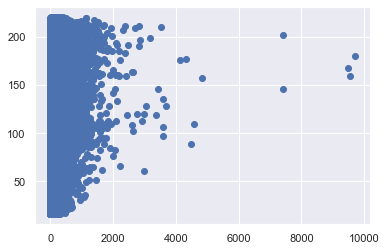

In [189]:
sns.set()
plt.plot(df_y, popularity_est.predict(df_X), 'o'); 

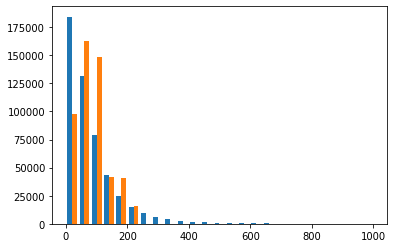

In [112]:
plt.hist([df_y[df_y<1000], popularity_est.predict(df_X)[df_y<1000]], 25); 

In [358]:
# popularity_est[-1].sparse_coef_
# popularity_est[-1].coef_

In [113]:
df_X.columns

Index(['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'dayofweek_0',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6', 'avg_popularity'],
      dtype='object')

#### Cross validation

In [377]:
popularity_est.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standard_scaler', 'polynomial_trans', 'lr', 'standard_scaler__copy', 'standard_scaler__feature_range', 'polynomial_trans__degree', 'polynomial_trans__include_bias', 'polynomial_trans__interaction_only', 'polynomial_trans__order', 'lr__alpha', 'lr__copy_X', 'lr__fit_intercept', 'lr__max_iter', 'lr__normalize', 'lr__random_state', 'lr__solver', 'lr__tol'])

In [ ]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    popularity_est,
    {"lr__alpha": np.logspace(0, 3, 5)},  # range of hyperparameters to test
    cv=10,  # 10-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
)
gs.fit(df_X, df_y)

In [369]:
gs.score(df_X, df_y)

0.37397731985016536

In [373]:
print(gs.best_params_)
print(gs.best_score_)

{'lr__alpha': 177.82794100389228}
0.30114205500362573


### Use Pipeline to organize the model
Start from the dataframe df_popularity, you'd like to use features related to time and weather to predict the curr_popularity. 

categorical features: `hour`, `dayofweek`, `fsq_type`
numerical features: `temp`, `humidity`, `precip`, (date can be added later on)

All features should be first transformed accordingly, pass with polynomial preprocessing (interaction), scaling, and then regressor. 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


In [126]:
df_popularity['datetime_hour'][0]

Timestamp('2021-04-07 01:00:00')

In [115]:
# since the weather data were not complete - only model data before 2021-04-10 for now
# df_popularity = df_popularity[df_popularity['datetime_hour']<'2021-04-21 01:00:00']

In [127]:
df_popularity.shape

(507886, 35)

In [128]:
df_popularity['curr_popularity'].describe()

count    507886.000000
mean         86.235409
std         104.674068
min           1.000000
25%          26.000000
50%          60.000000
75%         111.000000
max        9699.000000
Name: curr_popularity, dtype: float64

In [133]:
# TODO: do something to clear up noise in curr_popularity as well?
# df_popularity = df_popularity[df_popularity['curr_popularity']<1000]

In [118]:
print(df_popularity.shape)
df_popularity.columns

(507886, 35)


Index(['datetime_hour', 'id', 'curr_popularity', 'rating_n', 'request_id',
       'avg_popularity', 'address_city', 'fsq_type_name_simplified', 'rating',
       'datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew', 'precip',
       'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'datetime',
       'location', 'latitude', 'longitude', 'hour', 'dayofweek'],
      dtype='object')

In [130]:
df_popularity_y = df_popularity['curr_popularity']
all_feature_columns = ['id', 'avg_popularity', 'fsq_type_name_simplified', 
                       'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 
                       'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 
                       'conditions', 'rating',
                       'hour', 'dayofweek']
df_popularity_X = df_popularity[all_feature_columns]

X_train, X_test, y_train, y_test = train_test_split(
    df_popularity_X, df_popularity_y, random_state=42)

In [55]:
# feature collinearity:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(df_popularity_X).correlation
# corr_linkage = hierarchy.ward(corr)
# dendro = hierarchy.dendrogram(
#     corr_linkage, labels=all_feature_columns, ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro['ivl']))

# ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
# ax2.set_yticklabels(dendro['ivl'])
# fig.tight_layout()
# plt.show()

In [140]:
categorical_columns = ['hour', 'dayofweek', 'conditions', 'fsq_type_name_simplified']
# numerical_columns = ['avg_popularity', 'temp', 'humidity', 'dew', 'precip', 'windspeed', 
#                      'pressure', 'visibility', 'cloudcover', 'rating']
numerical_columns = ['avg_popularity', 'temp', 'humidity', 'dew', 'precip', 'windspeed', 'cloudcover', 'rating']

# preprocessing for numerical and categorical features
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=None, strategy='constant')),#strategy='most_frequent'; 'constant' for string type will be imputed with 'missing_value'
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaling', MaxAbsScaler())
])

# apply preprocessing to each column [TODO: but then you couldn't do Polynomial within 'num'??]
features = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

est = Pipeline([
    ('feature', features),
    ('estimator', RandomForestRegressor(n_estimators=20, max_depth=20, min_samples_leaf=10))
])
est.fit(X_train, y_train)

print(f'R^2 score using selected columns and transformers (train): {est.score(X_train, y_train)}')
print(f'R^2 score using selected columns and transformers (test): {est.score(X_test, y_test)}')

R^2 score using selected columns and transformers (train): 0.4646713207495342
R^2 score using selected columns and transformers (test): 0.3356573992582331


In [145]:
import dill 

# with open('estimator_v1_Date_2021-03-16_2021-04-20.dill', 'wb') as f:
#     dill.dump(est, f)
    
# with open('estimator_v1_Date_2021-03-16_2021-04-20.dill', 'rb') as f:
#     est = dill.load(f)    

(-500, 700)

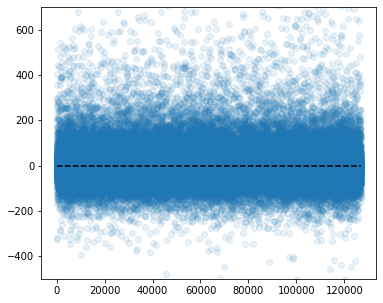

In [136]:
plt.figure(figsize=[6,5])
plt.plot(np.arange(len(y_test)), y_test - est.predict(X_test), 'o', alpha=0.1); 
plt.plot([0, len(y_test)], [0, 0], 'k--')
# plt.axis('equal'); plt.xlim([0, 300]); 
plt.ylim([-500, 700])

#### Feature importance

Text(0.5, 1.0, 'Random Forest Feature Importances (MDI)')

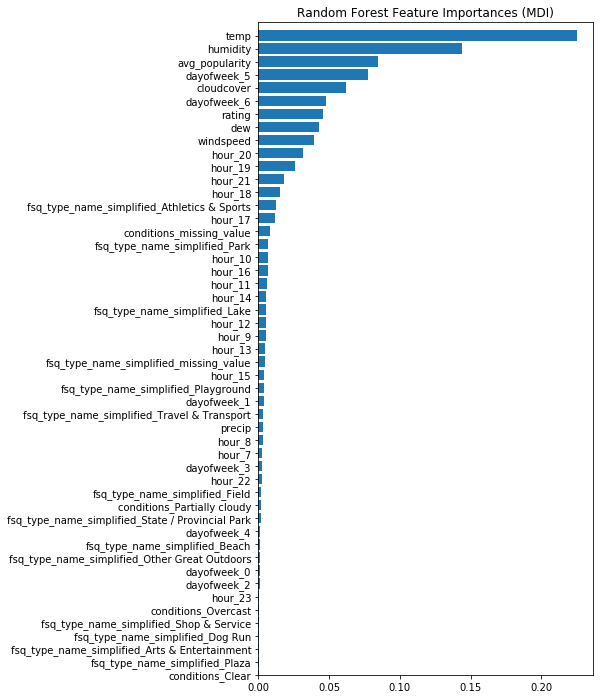

In [141]:
# get categorical feature names (since oneHotEncoder)
# Tree’s Feature Importance from Mean Decrease in Impurity (MDI)
ohe = (est.named_steps['feature'].named_transformers_['cat'].named_steps['onehot_encoder'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    est.named_steps['estimator'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
plt.figure(figsize=[6,12])
# fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, labels=feature_names[sorted_idx])
plt.ylim([40, len(feature_names)])
plt.title("Random Forest Feature Importances (MDI)")


#### Or to use permutation importance on the hold out set
Note that for multicollinear features, the permutation importance will show that none of the features are important

See more https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [142]:
result = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importances (test set)')

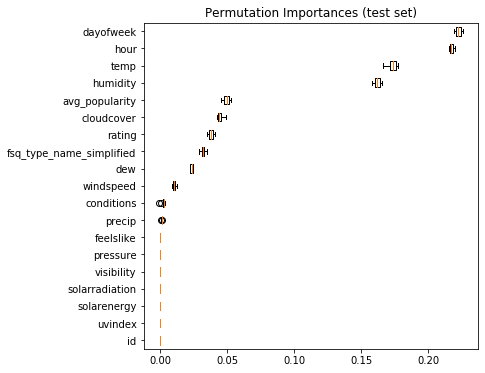

In [143]:
plt.figure(figsize=[6,6])
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importances (test set)")

In [12]:
import sklearn
sklearn.__version__

from sklearn import set_config
set_config(display='diagram')

est

Pipeline(steps=[('feature',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=None,
                                                                                 strategy='constant')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'dayofweek',
                                                   'conditions',
                                                   'fsq_type_name_simplified']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   MaxAbsScaler())]),
                                                  ['avg_popularity', 'temp',
                                                   'humidity', 'precip',
                                                   'windspeed', 'rating'])])),
                ('estimator',
                 RandomForestRegressor(max_depth=20, n_estimators=20))])

In [34]:
# from sklearn.utils import estimator_html_repr

# with open('model_v1_Date_2021-03-16_2021-04-10.html', 'w') as f:
#     f.write(estimator_html_repr(est))

#### Hyperparameters gridsearch

In [149]:
est.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature', 'estimator', 'feature__n_jobs', 'feature__remainder', 'feature__sparse_threshold', 'feature__transformer_weights', 'feature__transformers', 'feature__verbose', 'feature__cat', 'feature__num', 'feature__cat__memory', 'feature__cat__steps', 'feature__cat__verbose', 'feature__cat__imputer', 'feature__cat__onehot_encoder', 'feature__cat__imputer__add_indicator', 'feature__cat__imputer__copy', 'feature__cat__imputer__fill_value', 'feature__cat__imputer__missing_values', 'feature__cat__imputer__strategy', 'feature__cat__imputer__verbose', 'feature__cat__onehot_encoder__categories', 'feature__cat__onehot_encoder__drop', 'feature__cat__onehot_encoder__dtype', 'feature__cat__onehot_encoder__handle_unknown', 'feature__cat__onehot_encoder__sparse', 'feature__num__memory', 'feature__num__steps', 'feature__num__verbose', 'feature__num__imputer', 'feature__num__scaling', 'feature__num__imputer__add_indicator', 'feature__num__imputer__copy', 'featur

In [150]:
from sklearn.utils import shuffle

df_popularity_X_shuffle, df_popularity_y_shuffle = shuffle(df_popularity_X, df_popularity_y, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

parameters = {'estimator__max_depth': [10, 15, 20, 25, 30],
             'estimator__min_samples_leaf': [5, 10, 15, 20], 
             'estimator__n_estimators': [10, 20, 30], 
             'estimator__min_samples_split': [5, 10, 15]}

clf = RandomizedSearchCV(est, parameters, n_iter=35, cv=5, verbose=1)
clf.fit(df_popularity_X_shuffle, df_popularity_y_shuffle)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### Visualize prediction by parks

In [73]:
def show_prediction_per_park(park_id, df_popularity, info_df, gs):
    # get the predictions
#     sub_df = pd.concat([df_hour, df_dayweek, df_popularity[['temp','humidity', 'precip', 'curr_popularity']]], axis=1)
#     test_X = sub_df[df_popularity['id']==test_id].drop(columns=['curr_popularity', ])
#     predict_y = gs.predict(test_X.fillna(0))
    predict_y = gs.predict(df_popularity_X[df_popularity_X['id']==park_id])
    
    # plot data df_y
    sub_df = df_popularity[df_popularity['id']==park_id]
    plt.figure(figsize=[15,3])

    plt.plot(sub_df['datetime_hour'], sub_df['curr_popularity'], 'o')
    plt.legend(info_df[info_df['id']==park_id]['name'])
    plt.plot(sub_df['datetime_hour'], predict_y, '^') #fill in 0 for missing values #, markersize=10

    plt.figure(figsize=[15,3])
    plt.plot(sub_df['datetime_hour'], df_popularity[df_popularity['id']==test_id]['dew'], 'o')
    plt.plot(sub_df['datetime_hour'], df_popularity[df_popularity['id']==park_id]['humidity'], '^')
    

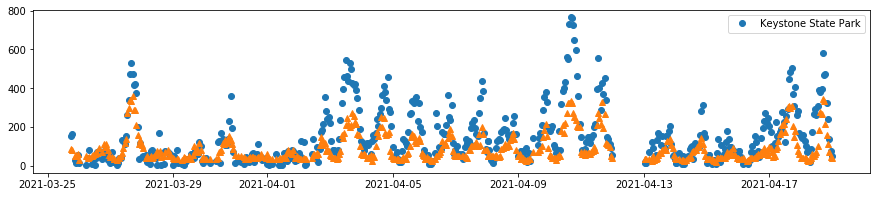

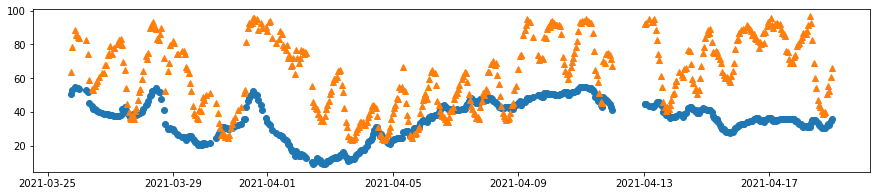

In [137]:
test_id = 'ChIJy2dLH7TMNIgRnKnsPaq4AeM' 
show_prediction_per_park(test_id, df_popularity, info_df, est)

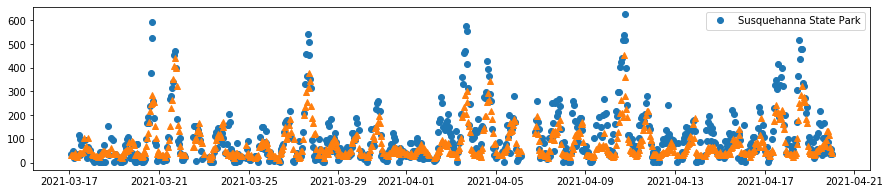

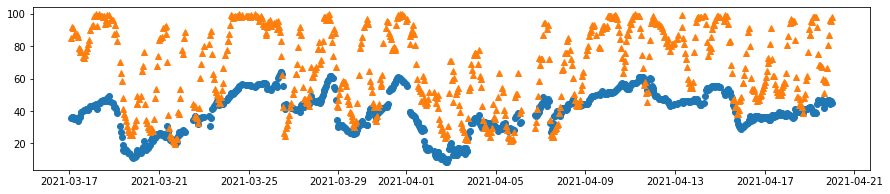

In [138]:
test_id = 'ChIJ2R92Tl7Gx4kRO6G7NcWtNhk' 
show_prediction_per_park(test_id, df_popularity, info_df, est)

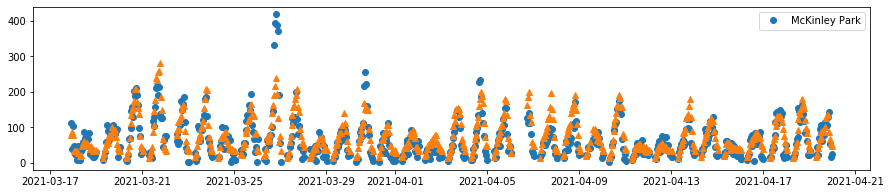

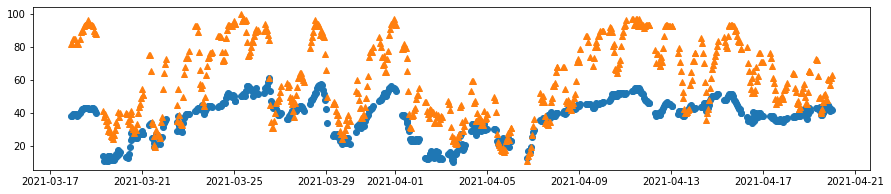

In [139]:
# some examples for 'Travel & Transport': #'ChIJreKNFonIxokRPfXi7jRKom0'#'ChIJU-taUeGcyIkRmOMiqeRIRks'
test_id = 'ChIJlT2okERFwokR616KLhTmZ8I' #playground
show_prediction_per_park(test_id, df_popularity, info_df, est)

### Seperate numerical and categorical features

In [186]:
df_popularity['datetime'].describe()

count                  321469
unique                    589
top       2021-04-10 14:00:00
freq                     1051
first     2021-03-17 02:00:00
last      2021-04-10 23:00:00
Name: datetime, dtype: object